In [1]:
!pip install azure-storage-blob

  Obtaining dependency information for azure-storage-blob from https://files.pythonhosted.org/packages/f6/82/24b0d7cf67ea63af86f11092756b8fe2adc1d55323241dc4107f5f5748e2/azure_storage_blob-12.19.0-py3-none-any.whl.metadata
  Obtaining dependency information for azure-core<2.0.0,>=1.28.0 from https://files.pythonhosted.org/packages/9c/f8/1cf23a75cb8c2755c539ac967f3a7f607887c4979d073808134803720f0f/azure_core-1.29.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for typing-extensions>=4.3.0 from https://files.pythonhosted.org/packages/24/21/7d397a4b7934ff4028987914ac1044d3b7d52712f30e2ac7a2ae5bc86dd0/typing_extensions-4.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typin

In [2]:
from azure.storage.blob import BlobServiceClient
import os

# Create a BlobServiceClient with an anonymous credential
blob_service_client = BlobServiceClient(account_url="https://radiantearth.blob.core.windows.net")

# Access the container
container_name = 'mlhub'  # or the name of the container you want to access
container_client = blob_service_client.get_container_client(container_name)

# List the blobs in the container
blob_list = container_client.list_blobs(name_starts_with='rti-rwanda-crop-type/imagery/_modeling')

# Colab directory to store data
colab_directory = './data_drone'  # Colab's local directory

for blob in blob_list:
    blob_client = container_client.get_blob_client(blob)
    file_path = os.path.join(colab_directory, blob.name.replace('/', os.sep))

    # Create a local directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Download the blob
    try:
        with open(file_path, "wb") as download_file:
            download_file.write(blob_client.download_blob().readall())
        print(f"Downloaded {blob.name} to {file_path}")
    except Exception as e:
        print(f"Failed to download {blob.name}: {e}")

Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1281_Dec2018.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1281_Dec2018.png
Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1281_Jan2019.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1281_Jan2019.png
Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1296_Dec2018.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1296_Dec2018.png
Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1318_Dec2018.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1318_Dec2018.png
Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1318_Jan2019.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1318_Jan2019.png
Downloaded rti-rwanda-crop-type/imagery/_modeling/train/banana/1921_Feb2019.png to ./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/1921_Feb2019.png
Downloaded

In [3]:
!pip install torchsummary -q

In [4]:
!pip install Pillow -q

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import zipfile
from PIL import Image
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random
import warnings
from tqdm import tqdm
import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [6]:
# import libraries
from PIL import Image
import os
import json
import fiona
# import arrow
import math
import glob
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
from shapely.geometry import shape, mapping, GeometryCollection, box
from shapely.ops import transform
import pyproj
from tqdm.notebook import tqdm

import shapely
import geopandas as gpd # Similar to pandas but also loads geometries into dataframes
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import tifffile as tiff
from PIL import Image

import cv2

import torch.nn as nn
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

import warnings
import urllib3
warnings.filterwarnings("ignore", category=urllib3.exceptions.InsecureRequestWarning)

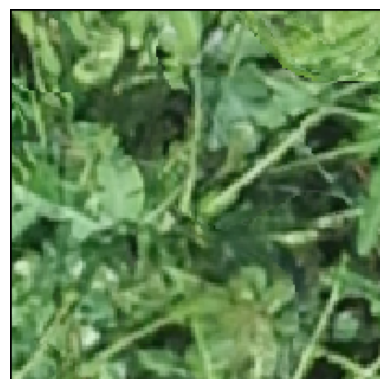

In [7]:

# Specify the path to your image
file_path = "./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana/R_490_Dec2018.png"

# Open the image
image = Image.open(file_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [8]:

def count_images_in_directory(directory_path):
    """
    Count the number of image files in each subdirectory of the given directory.
    Returns the total count of images.
    """
    # Supported image extension
    image_extensions = ['.png']

    total_image_count = 0

    # Iterate over each subdirectory in the main directory
    for subdirectory in os.listdir(directory_path):
        sub_dir_path = os.path.join(directory_path, subdirectory)

        # Make sure it's a directory
        if os.path.isdir(sub_dir_path):
            image_count = 0

            # Count image files
            for filename in os.listdir(sub_dir_path):
                if any(filename.endswith(ext) for ext in image_extensions):
                    image_count += 1

            print(f'Number of images in "{subdirectory}" of {os.path.basename(directory_path)}: {image_count}')
            total_image_count += image_count

    return total_image_count

# Main directory paths
train_dir_path = './data_drone/rti-rwanda-crop-type/imagery/_modeling/train'
validation_dir_path = './data_drone/rti-rwanda-crop-type/imagery/_modeling/validation'

# Count images in training and validation directories
total_train_images = count_images_in_directory(train_dir_path)
total_validation_images = count_images_in_directory(validation_dir_path)

# Print the total counts for each directory
print(f'\nTotal number of images in training: {total_train_images}\n')
print(f'Total number of images in validation: {total_validation_images}\n')

# Calculate and print the overall total
overall_total = total_train_images + total_validation_images
print(f'Overall total number of images (training + validation): {overall_total}')

Number of images in "other" of train: 600
Number of images in "legumes" of train: 290
Number of images in "banana" of train: 1330
Number of images in "maize" of train: 1660
Number of images in "forest" of train: 1016
Number of images in "structure" of train: 265
Number of images in "other" of validation: 150
Number of images in "legumes" of validation: 73
Number of images in "banana" of validation: 332
Number of images in "maize" of validation: 415
Number of images in "forest" of validation: 254
Number of images in "structure" of validation: 66

Total number of images in training: 5161

Total number of images in validation: 1290

Overall total number of images (training + validation): 6451


In [9]:
def create_dataframe_with_labels(directory_path):
    image_extensions = ['.png']
    data = {'Image': [], 'Label': []}

    for subdirectory in os.listdir(directory_path):
        sub_dir_path = os.path.join(directory_path, subdirectory)
        if os.path.isdir(sub_dir_path):
            for filename in os.listdir(sub_dir_path):
                if any(filename.endswith(ext) for ext in image_extensions):
                    image_path = os.path.join(sub_dir_path, filename)
                    data['Image'].append(image_path)
                    data['Label'].append(subdirectory)  # Subdirectory name as label

    return pd.DataFrame(data)

In [10]:

# Create dataframes
train_df = create_dataframe_with_labels(train_dir_path)
validation_df = create_dataframe_with_labels(validation_dir_path)

# Print dataframes
train_df.tail()

,Image,Label
5156,./data_drone/rti-rwanda-crop-type/imagery/_mod...,structure
5157,./data_drone/rti-rwanda-crop-type/imagery/_mod...,structure
5158,./data_drone/rti-rwanda-crop-type/imagery/_mod...,structure
5159,./data_drone/rti-rwanda-crop-type/imagery/_mod...,structure
5160,./data_drone/rti-rwanda-crop-type/imagery/_mod...,structure


In [11]:
def plot_images(column_name):
    sample_df = train_df.sample(12, random_state = 42)
    # Create subplots
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    # Iterate over the subplots
    for i, ax in enumerate(axes.flat):
        image_file_path = sample_df.iloc[i][column_name]
        image = Image.open(image_file_path)
        # Get the label name from the DataFrame
        label_name = sample_df.iloc[i]["Label"]

        # Plot the image and put labels
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis("off")

    # Display the plot
    plt.tight_layout()
    plt.show()

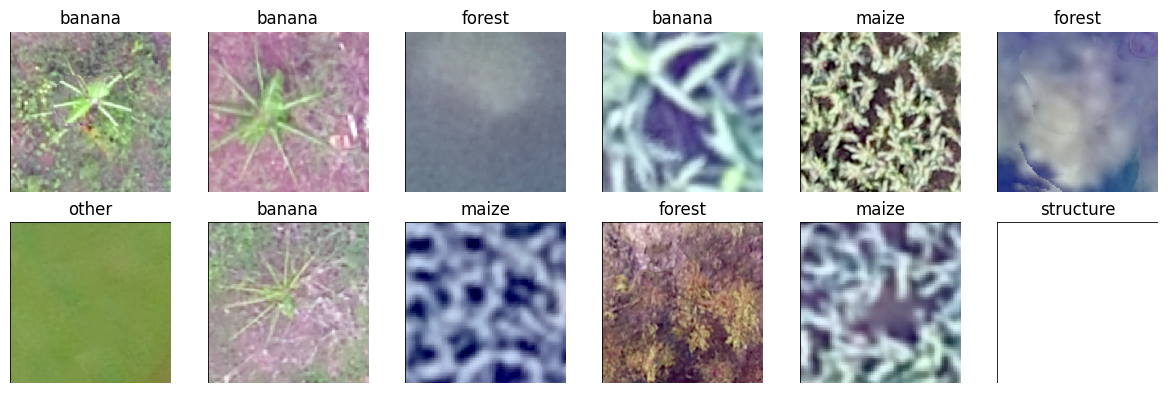

In [12]:
plot_images("Image")

In [13]:
config = {
    'batch_size': 128,
    'lr': 0.001,
    'epochs': 2,
}

In [14]:
types = ['forest', 'banana', 'other', 'structure', 'legumes', 'maize']

In [15]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.extended_df = df  # Use the df parameter passed to the method
        self.transform = transform

    def __len__(self):
        return len(self.extended_df)

    def __getitem__(self, idx):
        source_img_path = self.extended_df.iloc[idx]["Stacked Image"]
        label_name = self.extended_df.iloc[idx]["Label"]

        with Image.open(source_img_path) as img:
            if self.transform:
                img = self.transform(img)
        label = types.index(label_name)
#         label = {'forest': 0, 'banana': 1, 'other': 2, 'structure': 3, 'legumes': 4, 'maize': 5}
#         label = label_dict[label_name.capitalize()]

        return img, label

In [16]:
import torchvision

In [17]:
# import the libraries as shown below
from matplotlib import pyplot
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [18]:
from keras.preprocessing.image import img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator,load_img

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from glob import glob

In [20]:
import seaborn as sns

Load data for visualisation

In [21]:
labels = ['forest', 'banana', 'other', 'structure', 'legumes', 'maize']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [22]:
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append((resized_arr, class_num))
            except Exception as e:
                print(e)
    return data


In [23]:
#Now we can easily fetch our train and validation data.
train_Image_path = get_data('./data_drone/rti-rwanda-crop-type/imagery/_modeling/train')
test_Image_path = get_data('./data_drone/rti-rwanda-crop-type/imagery/_modeling/validation')

In [24]:
# train_path

Visualize the train data analysis

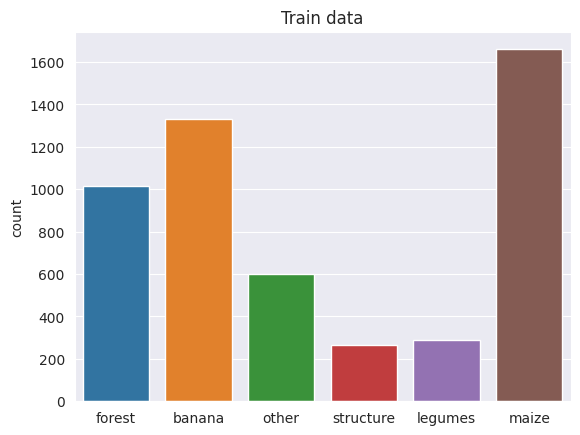

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code for creating the list 'l'
l = []
for i in train_Image_path:
    if i[1] == 0:
        l.append("forest")
    elif i[1] == 1:
        l.append("banana")
    elif i[1] == 2:
        l.append("other")
    elif i[1] == 3:
        l.append("structure")
    elif i[1] == 4:
        l.append("legumes")
    elif i[1] == 5:
        l.append("maize")

# Create countplot with 'hue' parameter
sns.set_style('darkgrid')
sns.countplot(x=l).set_title('Train data')

# Show the plot
plt.show()


Visualize the Validation data data analysis

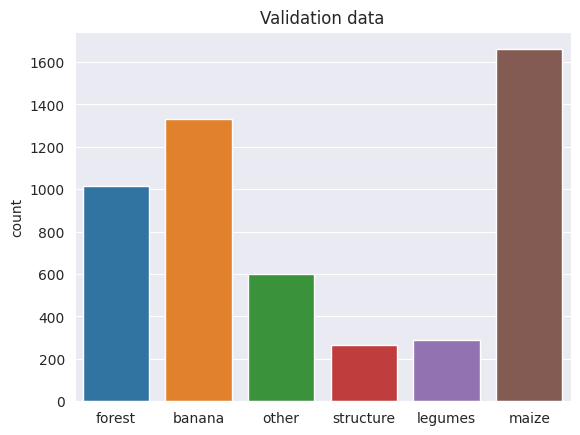

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code for creating the list 'l'
l = []
for i in train_Image_path:
    if i[1] == 0:
        l.append("forest")
    elif i[1] == 1:
        l.append("banana")
    elif i[1] == 2:
        l.append("other")
    elif i[1] == 3:
        l.append("structure")
    elif i[1] == 4:
        l.append("legumes")
    elif i[1] == 5:
        l.append("maize")

# Create countplot with 'hue' parameter
sns.set_style('darkgrid')
sns.countplot(x=l).set_title('Validation data')

# Show the plot
plt.show()

In [27]:
# re-size all the images 
IMAGE_SIZE = [224, 224]

# fetch train and validation data.
train_path = './data_drone/rti-rwanda-crop-type/imagery/_modeling/train'
test_path = './data_drone/rti-rwanda-crop-type/imagery/_modeling/validation'

In [28]:
import numpy as np
from tensorflow.keras.utils import to_categorical

class MixupCutmixGenerator():
    def __init__(self, datagen, batch_size=32, img_size=224, num_classes=6, mixup_prob=0.5, cutmix_prob=0.5):
        self.datagen = datagen
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.mixup_prob = mixup_prob
        self.cutmix_prob = cutmix_prob

    def mixup(self, images, labels, alpha=1.0):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        batch_size = labels.shape[0]
        index = np.random.permutation(batch_size)
        mixed_images = lam * images + (1 - lam) * images[index]
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        return mixed_images, mixed_labels

    def cutmix(self, images, labels, alpha=1.0):
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        batch_size = labels.shape[0]
        index = np.random.permutation(batch_size)
        bbx1, bby1, bbx2, bby2 = self.rand_bbox(images.shape[1:], lam)
        images[:, bbx1:bbx2, bby1:bby2, :] = images[index, bbx1:bbx2, bby1:bby2, :]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[1:] ** 2))
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        return images, mixed_labels

    def rand_bbox(self, size, lam):
        W = size[0]
        H = size[1]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        return bbx1, bby1, bbx2, bby2

    def __call__(self):
        while True:
            images, labels = next(self.datagen)
            labels = to_categorical(labels, self.num_classes)
            p = np.random.rand()
            if p < self.mixup_prob:
                images, labels = self.mixup(images, labels)
            elif p < self.mixup_prob + self.cutmix_prob:
                images, labels = self.cutmix(images, labels)
            yield images, labels


In [29]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:

# Define the number of folds
n_folds = 5

# Create a data generator
# datagen = ImageDataGenerator(rescale=1./255)

# Get the list of images
image_files = os.listdir(train_path)
image_files = [os.path.join(train_path, f) for f in image_files]

In [31]:
kfold = KFold(n_splits=n_folds, shuffle=True)


In [32]:
# # K-fold Cross Validation model evaluation
# fold_no = 1
# for train, test in kfold.split(image_files):
#     print(f'------------------------------------------------------------------------')
#     print(f'Training for fold {fold_no} ...')
#       # Create a new data generator
#     train_datagen = train_datagen.flow_from_directory(
#           directory=train_path,
#           target_size=(224, 224),
#           batch_size=32,
#           class_mode='categorical',
#           subset='training')

#     validation_datagen = test_datagen.flow_from_directory(
#           directory=train_path,
#           target_size=(224, 224),
#       batch_size=32,
#       class_mode='categorical',
#       subset='validation')

In [68]:

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [69]:
train_generator = MixupCutmixGenerator(train_datagen, batch_size=128, img_size=img_size, num_classes=6)


In [70]:
batch_size=32

In [71]:
fold_no = 5
for train, test in kfold.split(image_files):
    print(f'------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    train_generator = train_datagen.flow_from_directory(
            train_path,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)

    test_generator = test_datagen.flow_from_directory(
            test_path,
            target_size=(224, 224),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)

------------------------------------------------------------------------
Training for fold 5 ...
Found 5161 images belonging to 6 classes.
Found 1290 images belonging to 6 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Found 5161 images belonging to 6 classes.
Found 1290 images belonging to 6 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Found 5161 images belonging to 6 classes.
Found 1290 images belonging to 6 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Found 5161 images belonging to 6 classes.
Found 1290 images belonging to 6 classes.
------------------------------------------------------------------------
Training for fold 5 ...
Found 5161 images belonging to 6 classes.
Found 1290 images belonging to 6 classes.


In [72]:
# useful for getting number of output classes
folders = glob('./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/*')

In [73]:
folders

['./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/other',
 './data_drone/rti-rwanda-crop-type/imagery/_modeling/train/legumes',
 './data_drone/rti-rwanda-crop-type/imagery/_modeling/train/banana',
 './data_drone/rti-rwanda-crop-type/imagery/_modeling/train/maize',
 './data_drone/rti-rwanda-crop-type/imagery/_modeling/train/forest',
 './data_drone/rti-rwanda-crop-type/imagery/_modeling/train/structure']

Let use architecture from "J. Dhakshayani, S. S. Kulkarni, A. Mahapatra, B. Surendiran, and M. K. Nath, ‘Weed Classification
from Paddy Crops Using Convolutional Neural Network’, in Proceedings of the International Conference
on Paradigms of Communication, Computing and Data Sciences, M. Dua, A. K. Jain, A. Yadav, N. Kumar,
and P. Siarry, Eds., in Algorithms for Intelligent Systems. Singapore: Springer, 2022, pp. 493–507. doi:
10.1007/978-981-16-5747-442."  https://link.springer.com/chapter/10.1007/978-981-16-5747-4_42#Tab3

In [74]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load the VGG-16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Flatten layer
x = Flatten()(base_model.output)

# Fully connected layers
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)

# Output layer
output_layer = Dense(6, activation='softmax', name='dense')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Print model summary to check the architecture
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [75]:
len(folders)

6

Past achitecture, don't run it if you want to use model from the above mentioned paper

In [76]:
# # Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# # Here we will be using imagenet weights

# pre_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


# # don't train existing weights
# for layer in pre_model.layers:
#     layer.trainable = False

# for (i,layer) in enumerate(pre_model.layers):
#     print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

In [77]:
# def addTopModel(bottom_model, num_classes, D=512):
#     top_model = bottom_model.output
#     top_model = Flatten(name = "flatten")(top_model)
#     top_model = Dense(D, activation = "relu")(top_model)
#     top_model = Dropout(0.4)(top_model)
#     top_model = Dense(num_classes, activation = "softmax")(top_model)
#     return top_model




Model summary

In [78]:
# num_classes = len(folders)
# FC_Layer = addTopModel(pre_model, num_classes)
# model = Model(inputs=pre_model.input, outputs=FC_Layer)
# print(model.summary())

https://link.springer.com/chapter/10.1007/978-981-16-5747-4_42#Tab3

In [79]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [80]:
# tell the model what cost and optimization method to use
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.0001),
              metrics = ['accuracy'])

In [81]:
# fit the model
# Run the cell. It will take some time to execute
train_samples_count= 15483 #804
test_samples_count=1290 #201
epochs = 100
batch_size = 256 #32

checkpoint = ModelCheckpoint("./weightsr.h5",
                             monitor="val_loss",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


callback = [checkpoint]

history = model.fit_generator(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch = train_samples_count // batch_size,
    validation_steps=test_samples_count // batch_size,
    epochs = epochs,
    callbacks = callback)

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 3.5211 - accuracy: 0.5396
Epoch 1: val_loss improved from -inf to 1.34506, saving model to ./weightsr.h5
60/60 [==============================] - 33s 520ms/step - loss: 3.5211 - accuracy: 0.5396 - val_loss: 1.3451 - val_accuracy: 0.5750
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.6802
Epoch 2: val_loss did not improve from 1.34506
60/60 [==============================] - 28s 465ms/step - loss: 0.8507 - accuracy: 0.6802 - val_loss: 0.2938 - val_accuracy: 0.8938
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.7151
Epoch 3: val_loss did not improve from 1.34506
60/60 [==============================] - 28s 464ms/step - loss: 0.7594 - accuracy: 0.7151 - val_loss: 0.5185 - val_accuracy: 0.8125
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.7021
Epoch 4: val_loss did not improve from 1.34506
60/6

In [82]:
hjhj

NameError: name 'hjhj' is not defined

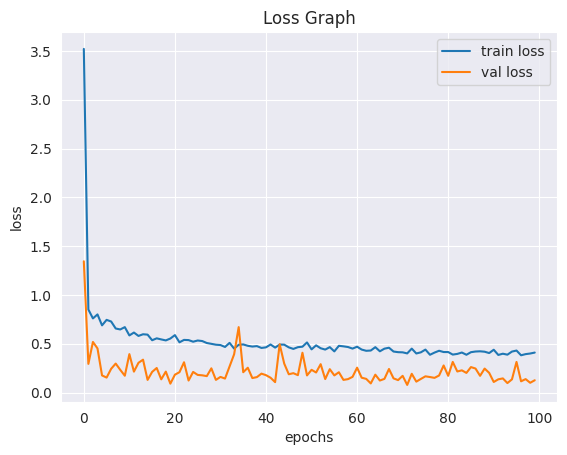

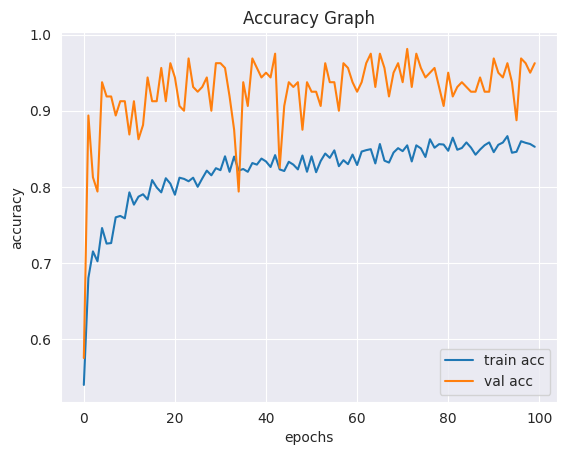

<Figure size 640x480 with 0 Axes>

In [83]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss Graph')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [84]:
model.load_weights("/kaggle/working/weightsr.h5")
class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix
[[183  20   0 103  20   6]
 [  0  62   0  25 107  60]
 [  0   2   3  31  33   4]
 [  0   2   2 359  30  22]
 [  2   8   5  30  83  22]
 [  0   0   2  12   7  45]]
Classification Report
              precision    recall  f1-score   support

      banana       0.99      0.55      0.71       332
      forest       0.66      0.24      0.36       254
     legumes       0.25      0.04      0.07        73
       maize       0.64      0.87      0.74       415
       other       0.30      0.55      0.39       150
   structure       0.28      0.68      0.40        66

    accuracy                           0.57      1290
   macro avg       0.52      0.49      0.44      1290
weighted avg       0.65      0.57      0.56      1290



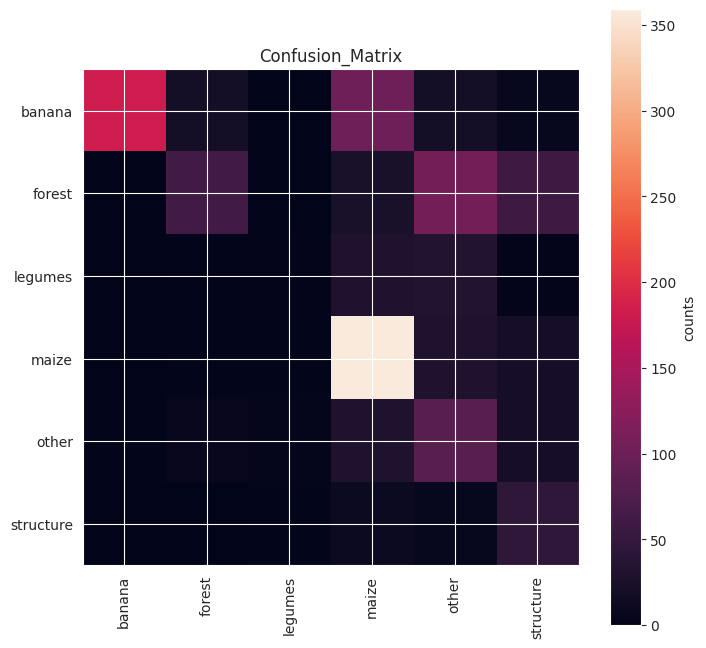

In [85]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation=None)
plt.title('Confusion_Matrix')
plt.colorbar(label="counts")
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

Random Image Predictions

In [ ]:
import cv2
import numpy as np

In [ ]:
def predict_crop(path,actual,class_labels):
    predict_datagen = ImageDataGenerator(rescale=1./255)
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    img = np.array(img).reshape((1, 224, 224, 3))
    Y_pred = model.predict(img)
    y_pred = np.argmax(Y_pred, axis=1)
    if y_pred == actual:
        print('Correct prediction')
    else:
        print("Messed up!!")
    print('Actual class "{0}" and predicted class "{1}"'.format(class_labels[actual],class_labels[int(y_pred)]))

In [ ]:
class_labels

In [ ]:
predict_crop('./data_drone/rti-rwanda-crop-type/imagery/_modeling/train/maize/2614_Dec2018_denoised.png',3,class_labels)